<a href="https://colab.research.google.com/github/DonghaeSuh/NLP_Pytorch/blob/main/Model/Transformer_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 마련

In [ ]:
import pandas as pd

In [ ]:
ls

drive/  sample_data/


In [ ]:
cd drive/MyDrive/Pytorch\ NLP/data_in/Chatbot

/content/drive/MyDrive/Pytorch NLP/data_in/Chatbot


In [ ]:
ls

2_Fine_ChatbotData.csv  ChatbotData.csv       Mecab-ko-for-Google-Colab/
best_weight/            Fine_ChatbotData.csv  vocab_word.csv


In [ ]:
vocab_word=pd.read_csv('vocab_word.csv')
train_data=pd.read_csv('2_Fine_ChatbotData.csv')

In [ ]:
BATCH_SIZE = 2
MAX_LEN = 25
EPOCHS = 30
NUM_LAYERS = 2
FEED_WORWARD_DIM=2048

In [ ]:
pip install torchtext==0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.1 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [ ]:
from torchtext import data

In [ ]:
# vocab 전용
V=data.Field(sequential=True,
             use_vocab=True,
             tokenize=str.split,
             init_token='<sos>',
             eos_token='<eos>',
             fix_length=MAX_LEN)

In [ ]:
Q=data.Field(sequential=True,
             use_vocab=True,
             tokenize=str.split,
             batch_first=True,
             fix_length=MAX_LEN)

A=data.Field(sequential=True,
             use_vocab=True,
             init_token='<sos>',
             eos_token='<eos>',
             tokenize=str.split,
             batch_first=True,
             fix_length=MAX_LEN)
LABEL=data.Field(sequential=True,
                 use_vocab=True,
                 eos_token='<eos>',
                 tokenize=str.split,
                 batch_first=True,
                 fix_length=MAX_LEN)

In [ ]:
from torchtext.data import TabularDataset

In [ ]:
train_data=TabularDataset('2_Fine_ChatbotData.csv',format='csv',fields=[('question',Q),('answer',A),('label',LABEL)],skip_header=True)
vars(train_data[0])

{'question': ['12시', '땡'],
 'answer': ['하루가', '또', '가네요'],
 'label': ['하루가', '또', '가네요']}

In [ ]:
vocab_data=TabularDataset('vocab_word.csv',format='csv',fields=[('vocab_word',V)],skip_header=True)

In [ ]:
V.build_vocab(vocab_data,min_freq=2)

Q.vocab=V.vocab
A.vocab=V.vocab
LABEL.vocab=V.vocab

In [ ]:
import random
import torch
SEED=123
random.seed(SEED)
torch.manual_seed(SEED)

train_data,val_data=train_data.split(split_ratio=0.9,random_state=random.seed(SEED))

In [ ]:
from torchtext.data import Iterator

In [ ]:
train_iter=Iterator(train_data,batch_size=BATCH_SIZE)
val_iter=Iterator(val_data,batch_size=BATCH_SIZE)

In [ ]:
batch=next(iter(train_iter))
batch.question

tensor([[ 742,  202, 1854, 5302,  211,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1],
        [  45,    0,    0, 2612,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1]])

In [ ]:
batch.answer

tensor([[   2, 4448, 4528, 3233,  858,  321, 4934,   89,    3,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1],
        [   2,  978, 1768,  539,   89,    3,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1]])

In [ ]:
batch.label

tensor([[4448, 4528, 3233,  858,  321, 4934,   89,    3,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1],
        [ 978, 1768,  539,   89,    3,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1]])

In [ ]:
train_iter=Iterator(train_data,batch_size=BATCH_SIZE)
val_iter=Iterator(val_data,batch_size=BATCH_SIZE)

# 모델 구현

In [ ]:
## hyperparameter
BATCH_SIZE=2
EPOCH=30
MAX_LEN=25
kargs={'max_len':MAX_LEN,
       'emb_dim':512,
       'num_layers':2,
       'num_heads':6,
       'ffn_dim':2048,
       'vocab_size':len(V.vocab),
       'p_rate':0.1
       }

device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import torch
import torch.nn as nn

### positional_encoding

In [ ]:
def positional_encoding(pos,d_model):
  pos=torch.arange(pos).unsqueeze(-1)
  i=torch.arange(d_model).unsqueeze(0)

  angle=pos/(torch.pow(10000,(2*i/d_model)))

  angle[:,0::2]=torch.sin(angle[:,0::2])
  angle[:,1::2]=torch.cos(angle[:,1::2])

  PE=angle.unsqueeze(0) # PE : ( 1, max_len, d_model )
  
  return PE # PE : ( 1, max_len, d_model )

<function matplotlib.pyplot.show(close=None, block=None)>

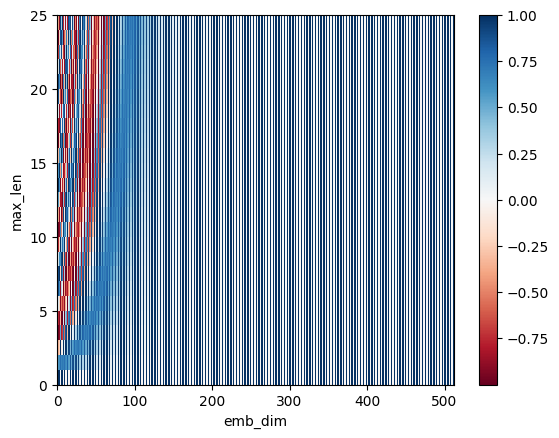

In [ ]:
import matplotlib.pyplot as plt

pe=positional_encoding(25,512)

plt.pcolormesh(pe[0],cmap='RdBu')
plt.xlabel('emb_dim')
plt.ylabel('max_len')
plt.colorbar()
plt.show

### 테스트

In [ ]:
a=torch.arange(5).unsqueeze(dim=-1) # position
b=torch.arange(10).unsqueeze(dim=0)
print(a)
print(b)
a*b

tensor([[0],
        [1],
        [2],
        [3],
        [4]])
tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18],
        [ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27],
        [ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36]])

In [ ]:
a=torch.Tensor([[2,3,1],[4,1,1]])
mask=torch.ones(a.size())
mask=(a==mask)*-1e9
mask

tensor([[-0.0000e+00, -0.0000e+00, -1.0000e+09],
        [-0.0000e+00, -1.0000e+09, -1.0000e+09]])

In [ ]:
print(mask[:,None,None,:],mask[:,None,None,:].size())

tensor([[[[-0.0000e+00, -0.0000e+00, -1.0000e+09]]],


        [[[-0.0000e+00, -1.0000e+09, -1.0000e+09]]]]) torch.Size([2, 1, 1, 3])


In [ ]:
a=torch.Tensor([[[1,2,3],[4,5,6]],[[3,2,1],[6,5,4]]])
b=torch.Tensor([[[-1,-1,-1]],[[1,1,1]]])
a+b

tensor([[[0., 1., 2.],
         [3., 4., 5.]],

        [[4., 3., 2.],
         [7., 6., 5.]]])

In [ ]:
a=torch.Tensor([False,True,True])
b=torch.Tensor([False,False,True])
torch.maximum(a,b)

tensor([0., 1., 1.])

### padding mask

In [ ]:
def padding_mask(inp):
  # inp : ( batch_size, max_len ) 
  # padding mask
  mask=torch.ones(inp.size())  # ( batch_size, max_len ) 
  mask=(inp==mask)*-1e9  # ( batch_size, max_len ) 
  padding_mask=mask[:,None,None,:] # ( batch_size, 1, 1, max_len )
  
  return padding_mask # ( batch_size, 1, 1, max_len )

### 테스트

In [ ]:
a=torch.ones(4,4)
print(a.triu(diagonal=0))
print(a.triu(diagonal=1)) # 이게 필요
print(a.triu(diagonal=-1))
c=a.triu(diagonal=1)
print(c.repeat(2,1,1,1).size())
c.repeat(2,1,1,1)

tensor([[1., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]])
tensor([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]])
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 0., 1., 1.]])
torch.Size([2, 1, 4, 4])


tensor([[[[0., 1., 1., 1.],
          [0., 0., 1., 1.],
          [0., 0., 0., 1.],
          [0., 0., 0., 0.]]],


        [[[0., 1., 1., 1.],
          [0., 0., 1., 1.],
          [0., 0., 0., 1.],
          [0., 0., 0., 0.]]]])

In [ ]:
a=a.triu(diagonal=1)
b=torch.Tensor([[0,0,1,1]])
torch.maximum(a,b)

tensor([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 1., 1.]])

In [ ]:
look_ahead_mask(torch.Tensor([[4,2,3,1,1],[1,2,3,2,1]]))

tensor([[[[-0.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
          [-0.0000e+00, -0.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09],
          [-0.0000e+00, -0.0000e+00, -0.0000e+00, -1.0000e+09, -1.0000e+09],
          [-0.0000e+00, -0.0000e+00, -0.0000e+00, -1.0000e+09, -1.0000e+09],
          [-0.0000e+00, -0.0000e+00, -0.0000e+00, -1.0000e+09, -1.0000e+09]]],


        [[[-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
          [-1.0000e+09, -0.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09],
          [-1.0000e+09, -0.0000e+00, -0.0000e+00, -1.0000e+09, -1.0000e+09],
          [-1.0000e+09, -0.0000e+00, -0.0000e+00, -0.0000e+00, -1.0000e+09],
          [-1.0000e+09, -0.0000e+00, -0.0000e+00, -0.0000e+00, -1.0000e+09]]]])

### look_ahead_mask

In [ ]:
def look_ahead_mask(tar):
  # tar : ( batch_size, max_len )

  # padding mask (padding 부분이 True,  아닌 부분이 False인 요소로 채워진 Tensor)
  mask=torch.ones(tar.size())  # ( batch_size, max_len ) 

  padding_mask=(tar==mask)  # ( batch_size, max_len ) 
  padding_mask=padding_mask[:,None,None,:] # ( batch_size, 1, 1, max_len )

  # look_ahead mask
  ones=torch.ones(tar.size()[1],tar.size()[1]) # ( max_len, max_len )
  look_ahead_mask=ones.triu(diagonal=1) # ( max_len, max_len )
  look_ahead_mask=look_ahead_mask.repeat(tar.size()[0],1,1,1) # ( batch_size, 1, ,max_len, max_len )

  look_ahead_mask=torch.maximum(padding_mask,look_ahead_mask)*-1e9
  
  return look_ahead_mask # ( batch_size, 1, ,max_len, max_len )

### Multi-head Attention
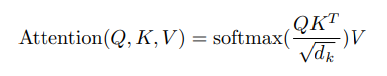

In [ ]:
import math

In [ ]:
class MultiheadAttention(nn.Module):
  def __init__(self,**kargs):
    super(MultiheadAttention,self).__init__()

    self.num_head=kargs['num_heads']
    self.d_model=kargs['d_model']
    self.depth=self.d_model/self.num_head  # d_model%num_head=0

    self.wq=nn.Linear(kargs['d_model'],kargs['d_model'])
    self.wk=nn.Linear(kargs['d_model'],kargs['d_model'])
    self.wv=nn.Linear(kargs['d_model'],kargs['d_model'])

    self.final_Linear=nn.Linear(kargs['d_model'],kargs['d_model'])

    self.softmax=nn.Softmax(dim=-1)

  def split_head(self,x): # x : ( batch_size, max_len, emb_dim )
    x = x.view( x.size()[0] , -1, self.num_head , self.depth ) 
    # ( batch_size, max_len, num_head, depth ) # num_head*depth=emb_dim

    return x.permute(0,2,1,3) # ( batch_size, num_head, max_len, depth )

  def forward(self,q,k,v,mask):
    # q,k,v = ( batch_size, max_len, emb_dim )
    # mask = ( batch_size, 1, 1, max_len ) or ( batch_size, 1, max_len, max_len )

    q = self.wq(q) # ( batch_size, max_len, emb_dim )
    k = self.wk(k) # ( batch_size, max_len, emb_dim )
    v = self.wv(v) # ( batch_size, max_len, emb_dim )

    root_dk=math.sqrt(k.size()[-1]) 

    # split by head
    q=self.split_head(q) # ( batch_size, num_head, max_len, depth )
    k=self.split_head(k) # ( batch_size, num_head, max_len, depth )
    v=self.split_head(v) # ( batch_size, num_head, max_len, depth )

    # scaled Dot-Product Attention
    score=torch.matmul(q, k.transpose(2,3))/root_dk # ( batch_size, num_haed, max_len, max_len )
    masked_score = score+mask # ( batch_size, num_haed, max_len, max_len )
    attention = torch.matmul(self.softmax(masked_score), v ) # ( batch_size, num_haed, max_len, depth )

    # Concat and Linear
    pre_permute = attention.permute(0,2,1,3) # ( batch_size, max_len, num_head, depth )
    z = pre_permute.view(pre_permute.size()[0],-1,self.d_model) # ( batch_size, max_len, emb_dim )
    z = self.final_Linear(z)

    return z # ( batch_size, max_len, emb_dim )  <= q,k,v of next Encoder 

### 테스트

In [ ]:
a=torch.Tensor([[[1,2,3,4],[4,5,6,7]],[[7,8,9,10],[10,11,12,13]]])
print(a,a.size(),sep='\n')
b=a.view(2,-1,2,2)
print(b,b.size(),sep='\n')
c=b.permute(0,2,1,3)
print(c,c.size(),sep='\n')

tensor([[[ 1.,  2.,  3.,  4.],
         [ 4.,  5.,  6.,  7.]],

        [[ 7.,  8.,  9., 10.],
         [10., 11., 12., 13.]]])
torch.Size([2, 2, 4])
tensor([[[[ 1.,  2.],
          [ 3.,  4.]],

         [[ 4.,  5.],
          [ 6.,  7.]]],


        [[[ 7.,  8.],
          [ 9., 10.]],

         [[10., 11.],
          [12., 13.]]]])
torch.Size([2, 2, 2, 2])
tensor([[[[ 1.,  2.],
          [ 4.,  5.]],

         [[ 3.,  4.],
          [ 6.,  7.]]],


        [[[ 7.,  8.],
          [10., 11.]],

         [[ 9., 10.],
          [12., 13.]]]])
torch.Size([2, 2, 2, 2])


In [ ]:
d=c.permute(0,2,1,3)
print(d,d.size(),sep='\n')
e=d.view(d.size()[0],-1,4)
print(e,e.size(),sep='\n')

tensor([[[[ 1.,  2.],
          [ 3.,  4.]],

         [[ 4.,  5.],
          [ 6.,  7.]]],


        [[[ 7.,  8.],
          [ 9., 10.]],

         [[10., 11.],
          [12., 13.]]]])
torch.Size([2, 2, 2, 2])
tensor([[[ 1.,  2.,  3.,  4.],
         [ 4.,  5.,  6.,  7.]],

        [[ 7.,  8.,  9., 10.],
         [10., 11., 12., 13.]]])
torch.Size([2, 2, 4])


In [ ]:
c.transpose(2,3)/10

tensor([[[[0.1000, 0.4000],
          [0.2000, 0.5000]],

         [[0.3000, 0.6000],
          [0.4000, 0.7000]]],


        [[[0.7000, 1.0000],
          [0.8000, 1.1000]],

         [[0.9000, 1.2000],
          [1.0000, 1.3000]]]])

### Feed Forward Network

In [ ]:
def FeedForward(**kargs):
    return nn.Sequential(nn.Linear(kargs['d_model'],kargs['ffn_dim']),
                         nn.ReLU(),
                         nn.Linear(kargs['ffn_dim'],kargs['d_model'])) # ( batch_size, max_len, emb_dim )

## Encoder

### Encoder Layer

In [1]:
class EncoderLayer(nn.Module):
  def __init__(self,**kargs):
    super(EncoderLayer,self).__init__()

    self.mha=MultiheadAttention(**kargs)
    self.ffn=FeedForward(**kargs)

    self.Norm1=nn.LayerNorm(kargs['d_model'],eps=1e-6)
    self.Norm2=nn.LayerNorm(kargs['d_model'],eps=1e-6)

    self.dropout1=nn.Dropout(kargs['p_rate'])
    self.dropout2=nn.Dropout(kargs['p_rate'])

  def forward(self,x,mask):
    # x = ( batch_size, max_len, emb_dim )
    # mask = ( batch_size, 1, 1, max_len ) or ( batch_size, 1, max_len, max_len )
    post_mha=self.mha(x,x,x,mask) # Multi-head Attention  # ( batch_size, max_len, emb_dim )
    post_mha=self.dropout1(post_mha)
    post_add_norm=self.Norm1(x+post_mha) # Add&Norm  # ( batch_size, max_len, emb_dim )

    post_ffn = self.FeedForward(post_add_norm) # ( batch_size, max_len, emb_dim )
    post_ffn = self.dropout2(post_ffn)

    output = self.Norm2(post_add_norm+post_ffn) # ( batch_size, max_len, emb_dim )
    
    return output # ( batch_size, max_len, emb_dim )

NameError: ignored

### Encoder

In [ ]:
class Encoder(nn.Module):
  def __init__(self,**kargs):
    super(Encoder,self).__init__()
    self.embedding=nn.Embedding(kargs['vocab_size'],kargs['emb_dim'])
    self.pe=positional_encoding(kargs['max_len'],kargs['emb_dim']) # PE : ( 1, max_len, d_model )
    self.dropout=nn.Dropout(kargs['p_rate'])

    self.encoder=[ EncoderLayer(**kargs) for _ in range(kargs['num_layers']) ]

  def forward(self,inp,mask):
      # inp = ( batch_size, max_len )
      # mask = ( batch_size, 1, 1, max_len ) or ( batch_size, 1, max_len, max_len )
      post_emb = self.embedding(inp) # ( batch_size, max_len, emb_dim )
      post_emb*=math.sqrt(kargs['d_model'])
      x+=self.pe # ( batch_size, max_len, emb_dim )

      for enc_layer in self.encoder:
        x = enc_layer(x,mask)

      return x # ( batch_size, max_len, emb_dim )

## Decoder

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self,**kargs):
    